In [1]:
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Goals of this project: predict employee retention and understand its main drivers.

Specific tasks:
1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.
2. What are the main factors that drive employee churn? Do they make sense? Explain your
findings.
3. If you could add to this data set just one variable that could help explain employee churn,
what would that be?

In [134]:
employee_data = pd.read_csv('employee_retention_data.csv')

In [135]:
employee_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


# Making the headcount table

Strategy for headcount table: create dataframe with row for each date for each company, group by company_id, for each row count employee if row date is between join_date and quit_date. How many companies are there? This is going to be a long table...

In [139]:
unique(employee_data.company_id.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [138]:
employee_data['join_date'] = pd.to_datetime(employee_data['join_date'])
employee_data['quit_date'] = pd.to_datetime(employee_data['quit_date'])

Make an array containing each date from 2011/01/24 to 2015/12/13 for dataframe construction.

In [6]:
date_array = np.arange('2011-01-23', '2015-12-13', dtype='datetime64[D]')
date_array[:5]

array(['2011-01-23', '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27'], dtype='datetime64[D]')

I'm going to first construct a dataframe with company information column-wise, then melt it into a long-form table

In [7]:
headcount_data = pd.DataFrame({'date': date_array})

In [8]:
def count_employees(company, date):
    company_df = employee_data[employee_data.company_id == company]
    # count rows where join_date <= date <= quit_date
    # if quit_date is NaT, then it should be considered larger than date
    condition = ((company_df.join_date <= date) & ((company_df.quit_date >= date) | (pd.isnull(company_df.quit_date))))
    return len(company_df[condition])

In [9]:
count_employees(1, str(headcount_data.iloc[2].values[0]))

27

In [10]:
for co in range(1, 13):
    headcount_data[co] = headcount_data.apply(lambda x: count_employees(co, x.date), axis=1)

That took a while to construct. I'll save it as a csv file and then read it if I need it again.

In [11]:
headcount_data.to_csv('headcount_data.csv')

In [25]:
headcount_data = pd.read_csv('headcount_data.csv', parse_dates=['date'])
headcount_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [26]:
headcount_data.head()

,date,1,2,3,4,5,6,7,8,9,10,11,12
0,2011-01-23,0,0,0,0,0,0,0,0,0,0,0,0
1,2011-01-24,25,17,9,12,5,3,1,6,3,0,0,0
2,2011-01-25,27,19,10,12,5,3,1,6,3,0,0,0
3,2011-01-26,29,19,12,13,6,3,1,6,3,0,0,0
4,2011-01-27,29,19,12,13,6,3,1,6,3,0,0,0


Okay, time to melt!

In [27]:
headcount_lf = pd.melt(headcount_data, id_vars='date', var_name='company', value_name='headcount')

In [28]:
headcount_lf.head()

,date,company,headcount
0,2011-01-23,1,0
1,2011-01-24,1,25
2,2011-01-25,1,27
3,2011-01-26,1,29
4,2011-01-27,1,29


In [29]:
headcount_lf.dtypes

date         datetime64[ns]
company              object
headcount             int64
dtype: object

Okay, now let's rename the columns so they match exactly what the prompt says.

In [30]:
headcount_lf.rename(columns={'date': 'day', 'company': 'company_id', 'headcount': 'employee_headcount'}, inplace=True)

Well, now that we have that table, we can plot the headcount for each company over time.

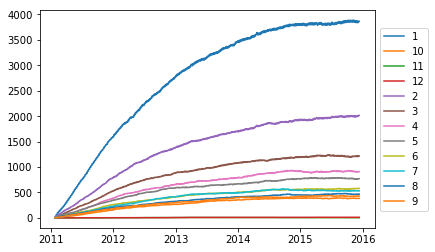

In [31]:
fig = plt.figure()
ax = plt.axes()
for co in unique(headcount_lf.company_id.values):
    co_df = headcount_lf[headcount_lf.company_id == co]
    ax.plot(co_df.day, co_df.employee_headcount, label=co)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Okay, that looks good. There don't appear to be any major events like layoffs that would confound a per-employee analysis of churn.

I want to add a column to the employee dataframe that is the length of time the person is employed (quit_date - join_date).

In [140]:
employee_data['length'] = employee_data['quit_date'] - employee_data['join_date']
employee_data['length'] = employee_data['length'].apply(lambda x: x.days)  # get days as integer value

In [141]:
employee_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


# Exploratory Data Analysis

Let's make some plots to look at relationships between variables. I'll make box plots for salary distributions by dept, seniority and length.

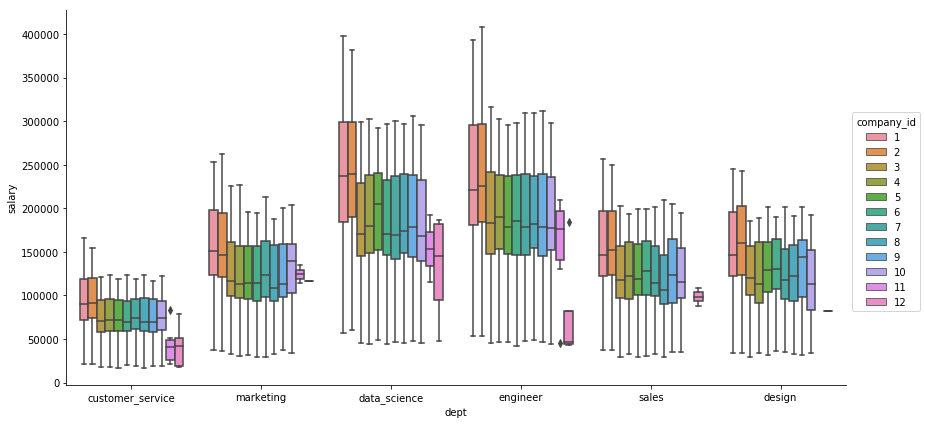

In [142]:
sns.factorplot(x='dept', y='salary', hue='company_id', data=employee_data, kind='box', size=6, aspect=2)

Cool. Already we can see that companies 1 and 2 pay significantly more across all departments, and 11 and 12 pay less.

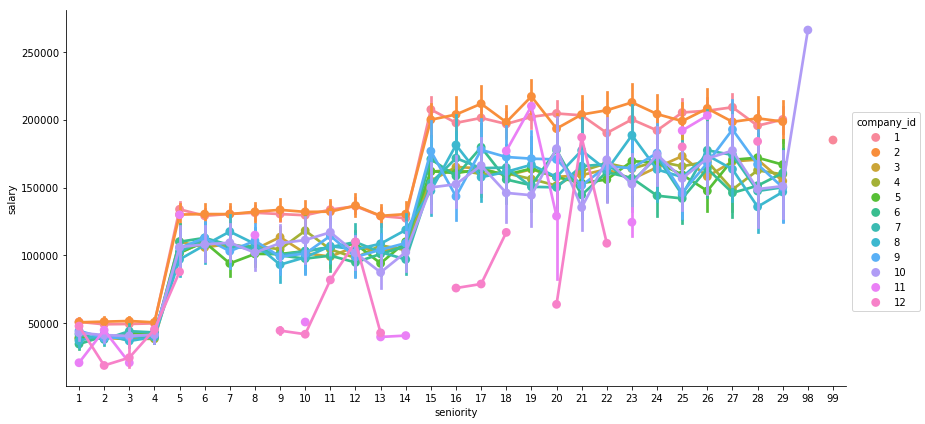

In [143]:
sns.factorplot(x='seniority', y='salary', hue='company_id', data=employee_data, kind='point', size=6, aspect=2)

Here we can see big jumps in salary at 5 years and 15 years of experience. Not sure what seniority levels of 98 and 99 mean - maybe CEOs? Maybe typos?

In [125]:
employee_data[employee_data.seniority > 29]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1123.0
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,864.0


Let's replace the null values in length with a value greater than the max length of 1726. I'll pick 1800 just to make it obviously different.

In [38]:
employee_data['length'].fillna(1800, inplace=True)

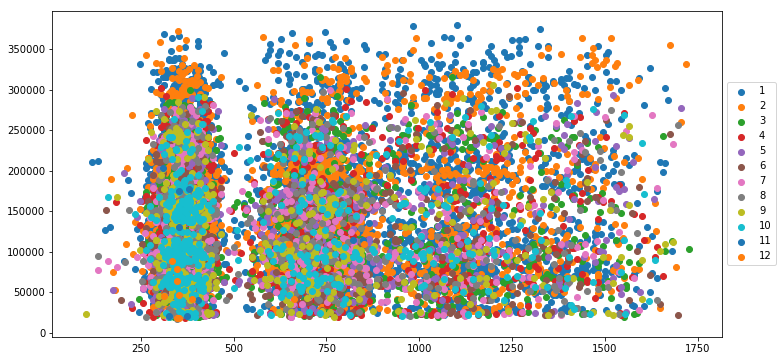

In [145]:
fig = plt.figure(figsize(12, 6))
ax = plt.axes()
for co in unique(employee_data.company_id.values):
    co_df = employee_data[employee_data.company_id == co]
    ax.scatter(co_df.length, co_df.salary, label=co)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Okay, not a lot of structure in comparing length to salary, except for a gap around 500 days (about 1.4 years). People who are paid more don't necessarily stay longer.

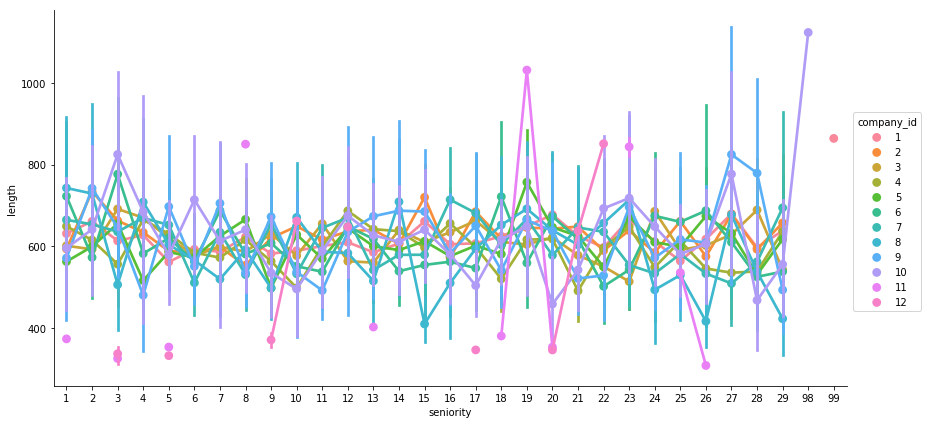

In [146]:
sns.factorplot(x='seniority', y='length', hue='company_id', data=employee_data, kind='point', size=6, aspect=2)

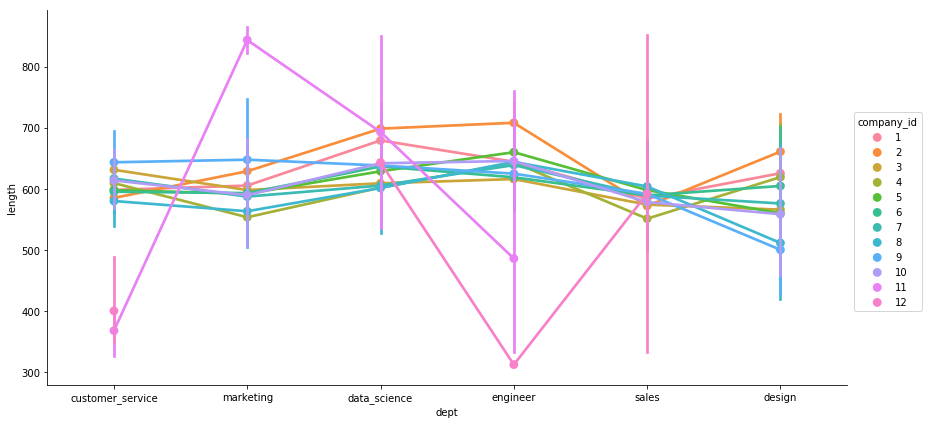

In [147]:
sns.factorplot(x='dept', y='length', hue='company_id', data=employee_data, kind='point', size=6, aspect=2)

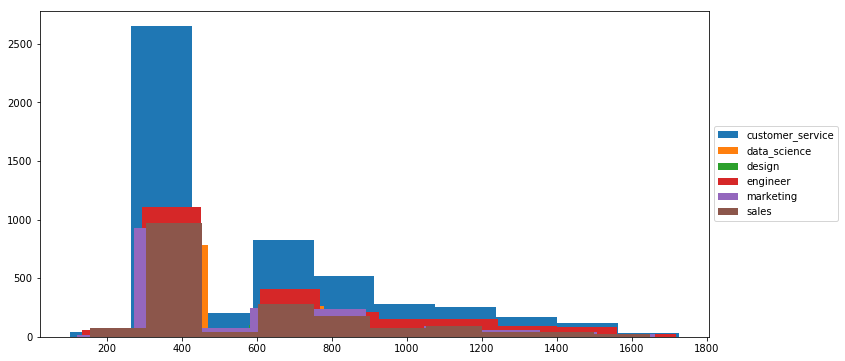

In [149]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
for dept in unique(employee_data.dept.values):
    dept_df = employee_data[employee_data.dept == dept]
    ax.hist(dept_df.length.dropna(), label=dept)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

So far, I don't see any relationships between length of time at a company and other factors in the table (dept, salary, and seniority). Predicting length of employment is going to be tricky with this dataset.

Looks like I'll want to learn about survival analysis to properly analyze this dataset.
Resource: https://www.cscu.cornell.edu/news/statnews/stnews78.pdf

What is the overall distribution of lengths of employment?

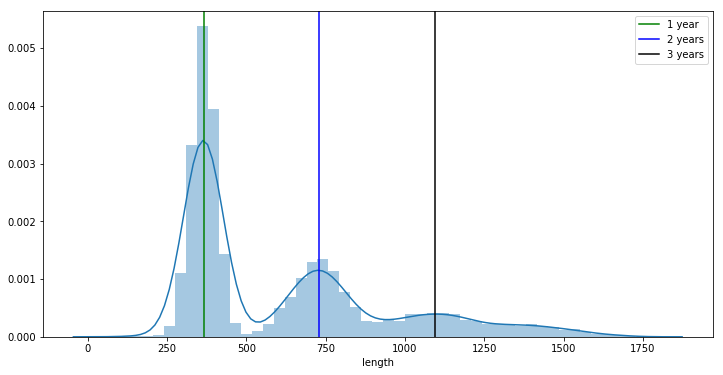

In [159]:
sns.distplot(employee_data.length.dropna())
plt.axvline(365, color='g', label='1 year')
plt.axvline(730, color='b', label='2 years')
plt.axvline(1095, color='k', label='3 years')
plt.legend()

Clearly, people tend to leave jobs most frequently at 1-year intervals. I see normal distributions around the 1-year, 2-year and 3-year marks with increasing variance. So the likelihood of leaving varies over time and is dependent on how long the person has been at the company in a non-monotonic way.

Given that gap around 500, a nonparametric model will probably perform better than a parametric model. Looks like the python Lifelines library will allow me to use Cox proportional hazards analysis, a semiparametric model used for survival analysis.

In [45]:
import lifelines

In [110]:
from lifelines.utils import datetimes_to_durations

# start_times is a vector of datetime objects
# end_times is a vector of (possibly missing) datetime objects.
# T is an array of durations, E is a boolean for whether the event occurred
T, E = datetimes_to_durations(employee_data.join_date, employee_data.quit_date, freq='D', fill_date = '2015-12-14')

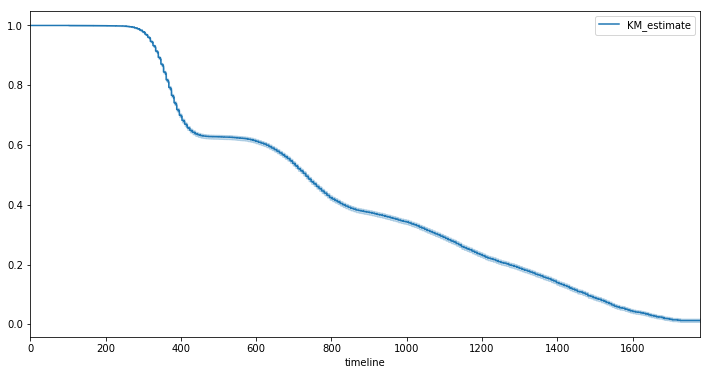

In [111]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.survival_function_
kmf.median_
kmf.plot()

I will construct a new dataframe to use the Cox proportional hazards model on this dataset. The dataframe's columns will be the variables, durations (T) and outcomes (E).

In [112]:
employee_data_CPH = employee_data.loc[:, 'company_id':'salary']
employee_data_CPH['T'] = T
employee_data_CPH['E'] = E
employee_data_CPH.drop(['dept'], axis=1, inplace=True)

In [114]:
employee_data_CPH.head()

,company_id,seniority,salary,T,E
0,7,28,89000.0,585.0,True
1,7,20,183000.0,340.0,True
2,4,14,101000.0,427.0,False
3,7,20,115000.0,389.0,True
4,2,23,276000.0,1040.0,True


In [115]:
employee_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,1800.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


To include the dept information, I need to one-hot encode it. The lifelines example uses patsy to do this.

In [117]:
import patsy
# convert company_id to string so patsy one-hot encodes it as well
employee_data['company_id'] = employee_data['company_id'].astype(str)
# the '-1' term refers to not adding an intercept column (a column of all 1s).
X = patsy.dmatrix('company_id + seniority + salary + dept -1', employee_data, return_type='dataframe')
X['T'] = T
X['E'] = E

In [118]:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(X, 'T', event_col='E')
cph.print_summary()

n=24702, number of events=13510

                        coef  exp(coef)   se(coef)       z      p   lower 0.95  upper 0.95     
company_id[1]        -0.1739     0.8404 66363.4457 -0.0000 1.0000 -130098.7355 130098.3877     
company_id[10]       -0.1782     0.8367 66363.4457 -0.0000 1.0000 -130098.7398 130098.3833     
company_id[11]        0.0341     1.0347 66363.4457  0.0000 1.0000 -130098.5274 130098.5957     
company_id[12]       -0.1625     0.8500 66363.4457 -0.0000 1.0000 -130098.7241 130098.3991     
company_id[2]        -0.2300     0.7945 66363.4457 -0.0000 1.0000 -130098.7916 130098.3316     
company_id[3]        -0.1680     0.8454 66363.4457 -0.0000 1.0000 -130098.7295 130098.3936     
company_id[4]        -0.1564     0.8552 66363.4457 -0.0000 1.0000 -130098.7180 130098.4052     
company_id[5]        -0.1919     0.8254 66363.4457 -0.0000 1.0000 -130098.7534 130098.3697     
company_id[6]        -0.1878     0.8288 66363.4457 -0.0000 1.0000 -130098.7493 130098.3738     
company

Kaplan-Meier Curves for each company

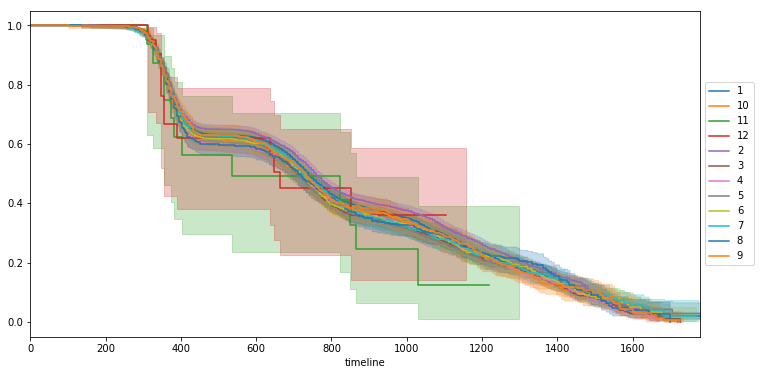

In [120]:
comps = employee_data.company_id

fig = plt.figure(figsize(12, 6))
ax = plt.axes()
for co in unique(employee_data.company_id.values):
    ix = (comps == co)
    kmf.fit(T[ix], E[ix], label=co)
    kmf.plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [121]:
cph.hazards_

,company_id[1],company_id[10],company_id[11],company_id[12],company_id[2],company_id[3],company_id[4],company_id[5],company_id[6],company_id[7],company_id[8],company_id[9],dept[T.data_science],dept[T.design],dept[T.engineer],dept[T.marketing],dept[T.sales],seniority,salary
coef,-0.173894,-0.178236,0.034136,-0.162483,-0.229988,-0.167953,-0.156384,-0.191851,-0.187758,-0.201809,-0.180751,-0.198134,0.04353,0.085247,0.016026,0.107496,0.154132,0.009686,-0.000002


In [122]:
# analyze without company id as variable
X = patsy.dmatrix('seniority + salary + dept -1', employee_data, return_type='dataframe')
X['T'] = T
X['E'] = E

cph = CoxPHFitter()
cph.fit(X, duration_col='T', event_col='E')

cph.print_summary()

n=24702, number of events=13510

                          coef  exp(coef)    se(coef)       z      p   lower 0.95  upper 0.95     
dept[customer_service] -1.0226     0.3597 133803.1067 -0.0000 1.0000 -262307.9528 262305.9077     
dept[data_science]     -0.9694     0.3793 133803.1067 -0.0000 1.0000 -262307.8996 262305.9608     
dept[design]           -0.9340     0.3930 133803.1067 -0.0000 1.0000 -262307.8642 262305.9963     
dept[engineer]         -0.9970     0.3690 133803.1067 -0.0000 1.0000 -262307.9272 262305.9333     
dept[marketing]        -0.9109     0.4022 133803.1067 -0.0000 1.0000 -262307.8411 262306.0194     
dept[sales]            -0.8641     0.4214 133803.1067 -0.0000 1.0000 -262307.7943 262306.0662     
seniority               0.0101     1.0102      0.0016  6.3795 0.0000       0.0070      0.0132  ***
salary                 -0.0000     1.0000      0.0000 -7.8344 0.0000      -0.0000     -0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concord

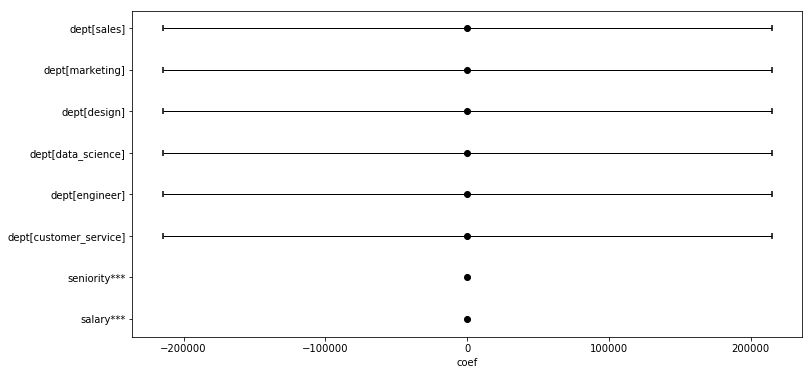

In [102]:
cph.plot()

From the Lifelines documentation:
A quick and visual way to check the proportional hazards assumption of a variable is to plot the survival curves segmented by the values of the variable. If the survival curves are the same “shape”, and differ only by constant factor, then the assumption holds. A more clear way to see this is to plot what’s called the loglogs curve: the log(-log(survival curve)) vs log(time). If the curves are parallel (and hence do not cross each other), then it’s likely the variable satisfies the assumption. If the curves do cross, likely you’ll have to “stratify” the variable (see next section). In lifelines, the KaplanMeierFitter object has a .plot_loglogs function for this purpose.

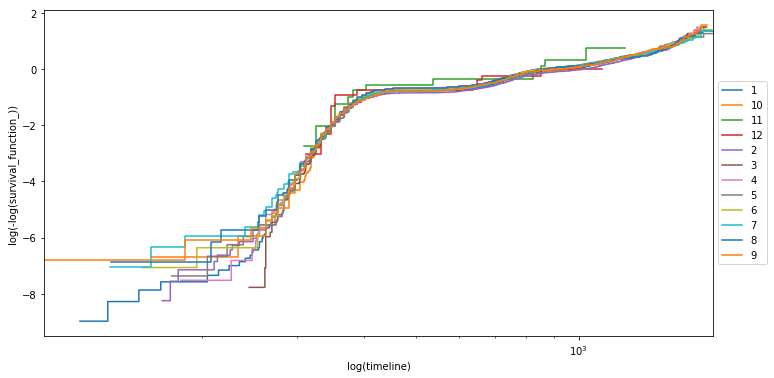

In [123]:
comps = employee_data.company_id
fig = plt.figure(figsize(12, 6))
ax = plt.axes()
for co in unique(employee_data.company_id.values):
    ix = (comps == co)
    kmf.fit(T[ix], E[ix], label=co)
    kmf.plot_loglogs(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

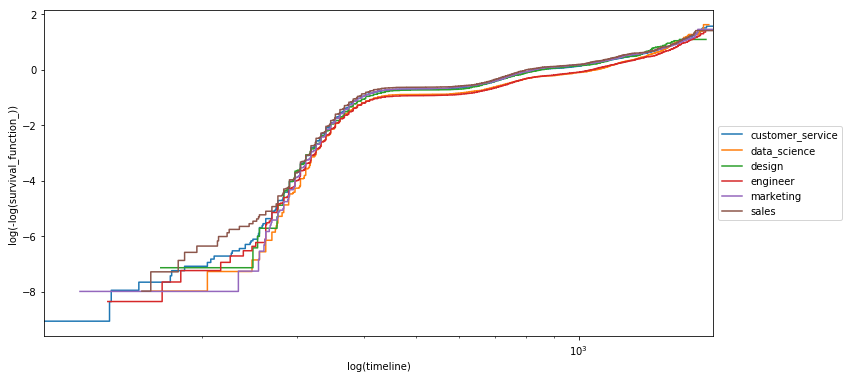

In [124]:
depts = employee_data.dept
fig = plt.figure(figsize(12, 6))
ax = plt.axes()
for dept in unique(employee_data.dept.values):
    ix = (depts == dept)
    kmf.fit(T[ix], E[ix], label=dept)
    kmf.plot_loglogs(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

It's difficult to tell if these curves satisfy the proportional hazards assumption, but they look mostly parallel. I'm going to stop here, since it's been more than 4 hours working on this. In general, the variables I have are not terribly predictive (C-index is 0.535, where 0.5 is random guess).

# On other variables

Based on the distribution of lengths, I found that people tend to leave a company at whole-year intervals, i.e. after 1 year, 2 years, or 3 years. I could engineer a feature that is a fraction representing where they are in the yearly cycle after joining a company. For example, a length of 1.2 years and 1.8 years would both be represented by 0.2, signifying the fraction of a year away from a whole year. This of course would be a time-varying feature, something that the method used above can't take in its current form.

A feature I could engineer from the data that I have is the size of the company. However, this would also be a time-varying covariate and the analysis method would have to be adjusted for this. 

Another time-varying covariate that could be informative is the employee's salary over time. Right now, I only have a single salary level for each employee. Changes in salary could be important in determining whether or not someone leaves a company.

Another piece of information missing is the reason for departure. This wouldn't be useful as a predictive feature, but it could be used to subset the data to increase signal. People who are fired presumably have different characteristics than people who leave for a better position.

If I could add only one variable, it would be salary over time.